In [1]:
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.settings import QiskitNatureSettings

QiskitNatureSettings.use_pauli_sum_op = False

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import Statevector

import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_orbitals = 4
op_dict = {
    "+_2 -_0": -1,
    "+_0 -_2": -1,
    "+_3 -_1": -1,
    "+_1 -_3": -1,
    "+_0 -_0 +_1 -_1": 0.5,
    "+_2 -_2 +_3 -_3": 0.5,
}

The Hubbard model is a prototypical model in condensed matter physics that describes electrons moving on a lattice. In its simplest form, each lattice site can be occupied by two electrons, one with spin up, one with spin down. The Hamiltonian reads $$H = - t \sum_{i,\sigma} a^\dagger_{i,\sigma} a_{i+1,\sigma} + a^\dagger_{i+1,\sigma} a_{i,\sigma} + U \sum_i n_{i, \uparrow} n_{i, \downarrow} \ ,$$ where the $i$ index runs over all sites of the lattice and $\sigma \in { \uparrow, \downarrow }$ denotes the spin of the electrons. $a^\dagger, a$ are creation and annihilation operators, respectively, and $n_{i, \sigma} = a^\dagger_{i,\sigma} a_{i,\sigma}$ is the corresponding number operator. The first term $\propto t$ is the kinetic energy term and is responsible for electrons hopping between neighboring lattice sites. The second term $\propto U$ corresponds to the potential energy mediated by the Coulomb repulsion, meaning electrons will pay an energy penalty if they occupy the same site.

You are given the Hamiltonian of a 2-site Hubbard model (corresponding to four qubits since each site can have spin up and spin down) in the format of a dictionary like we implemented in last week's exercise. The qubit register is structured such that $\bigotimes_i | q_{i,\uparrow} q_{i,\downarrow} \rangle$. In our 2-site case, this means $|q_{0, \uparrow} q_{0, \downarrow} q_{1, \uparrow} q_{1, \downarrow} \rangle$, i.e. the first two qubits encode the occupation of site-0 with a spin-up or -down electron, respectively, while the last two qubits encode the occupation of site-1 with a spin-up or -down electron.

Map the operator to Pauli-strings using qiskit-nature's built-in operator class FermionicOp and the JordanWignerMapper
Then compute the time evolution using Trotter circuits generated with Qiskit's PauliEvolutionGate
initializing the system in the localized (on site 0) state $|1100 \rangle$
for final time $t=5$ and $N_t=50$ time steps
Compute the following two observables for every time step (you can simply do this by evaluating exact statevectors)
the overlap with the localized (initial state) state
the sum of the number operators on site 0 and 1, $n_0 = n_{0, \uparrow} + n_{0, \downarrow}$
Plot the results for both quantities

## Solution

In [3]:
sec_q_op = FermionicOp(op_dict)

In [4]:
mapper = JordanWignerMapper()

pauli_strings = mapper.map(sec_q_op, register_length=num_orbitals)

print(pauli_strings)

SparsePauliOp(['IXZX', 'IYZY', 'XZXI', 'YZYI', 'IIII', 'IIZI', 'IIIZ', 'IIZZ', 'ZIII', 'IZII', 'ZZII'],
              coeffs=[-0.5  +0.j, -0.5  +0.j, -0.5  +0.j, -0.5  +0.j,  0.25 +0.j, -0.125+0.j,
 -0.125+0.j,  0.125+0.j, -0.125+0.j, -0.125+0.j,  0.125+0.j])


In [14]:
t_final = 5
N_t = 50
dt = t_final / N_t

psi_init = Statevector.from_label("0011")

evo_gate = PauliEvolutionGate(pauli_strings, time=dt)
qreg = QuantumRegister(num_orbitals)

## initialize the quantum circuit
qc = QuantumCircuit(qreg)
qc.initialize(psi_init.data, qreg)

overlaps = []
n_electrons_0 = []
n_electrons_1 = []

times = np.linspace(0, t_final, N_t + 1)
for t in times:
    qc.append(evo_gate, qargs=qreg)
    qc.barrier()

    psi_t = Statevector(qc)
    overlap = psi_t.inner(psi_init)
    
    overlaps.append(np.abs(overlap) ** 2)

    # we sum the probabilities starting with 10, 01 or 11
    # 01XX + 10XX + 11XX
    pre = ['10', '01', '11']
    sub = ['00', '01', '10', '11']

    value_0 = 0
    value_1 = 0
    for i in pre:
        for j in sub:
            f = 1
            if i == '11':
                f = 2
            
            value_0 += psi_t.probabilities_dict()[j + i] * f

            value_1 += psi_t.probabilities_dict()[i + j] * f
 
    n_electrons_0.append(value_0)
    n_electrons_1.append(value_1)

    # an electron at site 0 

    # n_electrons_0.append(psi_t.probabilities_dict()[0] + psi_t.probabilities_dict()[2])
    # n_electrons_1.append(psi_t.probabilities_dict()[1] + psi_t.probabilities_dict()[3])
    
    

Text(0, 0.5, 'Overlap')

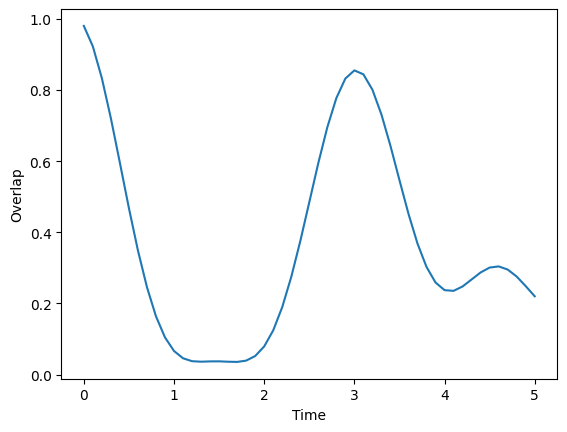

In [15]:
plt.plot(times, overlaps)
plt.xlabel("Time")
plt.ylabel("Overlap")

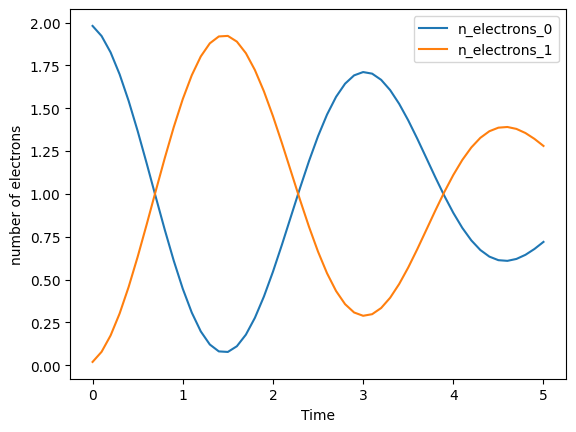

In [16]:
plt.plot(times, n_electrons_0, label="n_electrons_0")
plt.plot(times, n_electrons_1, label="n_electrons_1")
plt.xlabel("Time")
plt.ylabel("number of electrons")
plt.legend()